# **Klasifikasi suara manusia berdasarkan umur dan gender menggunakan metode FFT**

**Anggota Kelompok 4**

Ananda Keissa Az Zahra (24031554051)

Laili Nurrohmatul Fadhila Z. (24031554093)

Eka Putri Maharani (24031554121)

In [1]:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1Z4ijYI6ATbnAhUOJGUnxMeB6U8snR2GL"

Retrieving folder contents
Retrieving folder 1NCpNcYvTaKzdUMagF_UHJwsYU9g9niFw dataset_wav
Retrieving folder 16O-BATI9_opdTsMbiPDSGxUlJL4uLqH2 anak_cewe
Processing file 195YOwm-lrus7-bpeWUBsRaZQ_IOJv7e9 anak_cewe.wav
Processing file 1yHSVxgWLy_RKHdh767bGUBiLoObLGkIP anak_cewe2.wav
Processing file 1jlrk4_KnqHnchXIdyHy024O6dLN_EvQD anak_cewe3.wav
Retrieving folder 16YM70MYTYroiyC8OjJ-H4-HT_YUKjrU6 anak_laki
Processing file 138cFp1844YfjsMwUTdr6nhwej210hHmw anak_laki.wav
Processing file 1qBPGnOJHf2qxqopnpSd-CJaW4CCHQ3I5 anak_laki2.wav
Retrieving folder 1EqFbuDxuvjJhuiHeK880aGPW6gIcqDEP bayi
Processing file 1P_thNHW95IBOPO3qWQ7_Kc1xmcG1iaaE BAYI LAKI.wav
Processing file 1RUB3DHyGardd_mNqp-GDyNARIpw7BD1o bayi_laki2.wav
Processing file 1u-Sg7EGonyrSgVozGfBnxCsfpf_W_X7y bayi_laki3.wav
Retrieving folder 11975y4uXb9TaHd5VT78-2oLx-PG8Zrij dewasa_cewe
Processing file 1-iKrVC0jsTuKo32qPfV90IOkLPybIdIa dewasa_cewe.wav
Processing file 1ZBUxb9VCphbGls3X5MW4c81-5lEVCQwJ dewasa_cewe3.wav
Processing fil

**Install Library**

In [2]:
!pip install librosa numpy pandas scipy soundfile pydub matplotlib
!apt-get install -y ffmpeg
!pip install xlsxwriter

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.2 MB/s eta 0:00:00


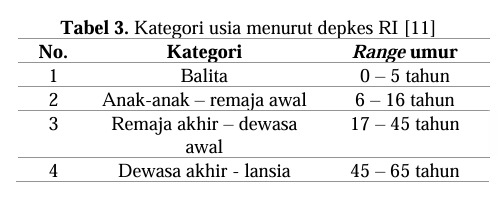

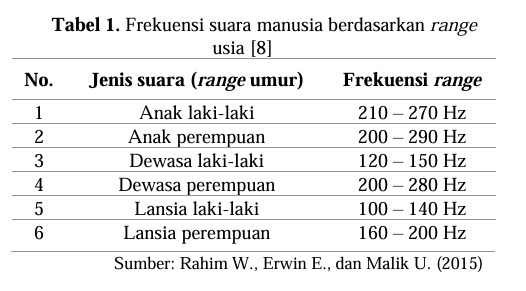

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
from pydub import AudioSegment
from IPython.display import Audio, display
import warnings

# Bandpass Filter(75-400 Hz)
def bandpass_filter(sinyal, sr, f_low=75, f_high=400):
    nyquist = 0.5 * sr
    b, a = scipy.signal.butter(
        4,
        [f_low / nyquist, f_high / nyquist],
        btype='band'
    )
    return scipy.signal.filtfilt(b, a, sinyal)

# Menghitung panjang FFT sebagai pangkat dua terdekat agar efisien secara komputasi.
def next_power_of_two(n):
    return 1 << (n - 1).bit_length() if n > 0 else 1

# FFT
def ekstraksi_fitur_fft(sinyal, sr):
    n_fft_min = 4096
    n_fft = max(n_fft_min, next_power_of_two(len(sinyal)))

    # Padding jika sinyal lebih pendek dari n_fft
    if len(sinyal) < n_fft:
        sinyal = np.pad(sinyal, (0, n_fft - len(sinyal)))

    # FFT domain waktu → frekuensi
    hasil_fft = np.fft.fft(sinyal)
    magnitude = np.abs(hasil_fft[:n_fft // 2 + 1])
    frekuensi = np.fft.fftfreq(n_fft, d=1/sr)[:n_fft // 2 + 1]

    # Estimasi F0 dari puncak spektrum (50–1000 Hz)
    mask_valid = (frekuensi >= 50) & (frekuensi <= 1000)
    if np.any(mask_valid):
        idx_puncak = np.argmax(magnitude[mask_valid])
        f0 = frekuensi[mask_valid][idx_puncak]
    else:
        f0 = 0

    # Spectral centroid
    if np.sum(magnitude) > 0:
        centroid = np.sum(frekuensi * magnitude) / np.sum(magnitude)
    else:
        centroid = 0

    # Spectral spread (bandwidth)
    spread = librosa.feature.spectral_bandwidth(
        S=magnitude.reshape(-1, 1),
        sr=sr
    )[0, 0]

    return {
        "F0": f0,
        "Centroid": centroid,
        "Spread": spread,
        "Magnitude": magnitude,
        "Frekuensi": frekuensi
    }
# klasifikasi
def klasifikasi_suara(f0):
    if f0 < 50:
        return "Noise / Hening"

    if 210 <= f0 <= 270:
        return "Anak-anak Laki-laki"

    if 200 <= f0 < 210:
        return "Anak-anak Perempuan"
    if f0 >= 290:
        return "Anak-anak (frekuensi tinggi)"

    if 270 < f0 < 290:
        return "Anak-anak Perempuan"

    if 120 <= f0 <= 150:
        return "Dewasa Laki-laki (17–45 tahun)"

    if 200 <= f0 <= 280:
        return "Dewasa Perempuan (17–45 tahun)"

    if 100 <= f0 < 120:
        return "Lansia Laki-laki (45–65 tahun)"

    if 150 < f0 < 160:
        return "Lansia Laki-laki (45–65 tahun)"

    if 160 <= f0 <= 200:
        return "Lansia Perempuan (45–65 tahun)"

    return "Tidak terklasifikasi"


def plot_analisis(sinyal_asli, sinyal_bersih, sr, fitur, nama_file):
    plt.figure(figsize=(10, 9))

    # Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(sinyal_asli, sr=sr, alpha=0.5, label="Asli")
    librosa.display.waveshow(sinyal_bersih, sr=sr, alpha=0.8, label="Bersih")
    plt.title("Waveform Sinyal Suara")
    plt.legend()
    plt.grid()

    # FFT Spectrum
    plt.subplot(3, 1, 2)
    plt.plot(fitur["Frekuensi"], fitur["Magnitude"])
    plt.axvline(fitur["F0"], color='r', linestyle='--', label=f'F0 = {fitur["F0"]:.1f} Hz')
    plt.xlim(0, 1000)
    plt.title("Spektrum Frekuensi (FFT)")
    plt.xlabel("Frekuensi (Hz)")
    plt.ylabel("Magnitudo")
    plt.legend()
    plt.grid()

    # Spectrogram
    plt.subplot(3, 1, 3)
    S = librosa.stft(sinyal_bersih, n_fft=1024)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")

    plt.tight_layout()
    plt.show()

def process_single_file(file_path):
    print(f"\nMemproses: {file_path}")

    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(16000).set_channels(1)
    sinyal_asli = np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0
    sr = 16000

    sinyal_filter = bandpass_filter(sinyal_asli, sr)
    sinyal_trim, _ = librosa.effects.trim(sinyal_filter, top_db=25)
    sinyal_bersih = librosa.util.normalize(sinyal_trim)

    fitur = ekstraksi_fitur_fft(sinyal_bersih, sr)
    kategori = klasifikasi_suara(fitur["F0"])

    print(f"F0: {fitur['F0']:.1f} Hz")
    print(f"Kategori: {kategori}")

    plot_analisis(sinyal_asli, sinyal_bersih, sr, fitur, os.path.basename(file_path))

    display(Audio(sinyal_asli, rate=sr))
    display(Audio(sinyal_bersih, rate=sr))


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


### **Suara Anak-Anak**

**Anak_Cewe**


Memproses: /content/Audio_Project/dataset_wav/anak_cewe/anak_cewe.wav
F0: 229.0 Hz
Kategori: Anak-anak Laki-laki


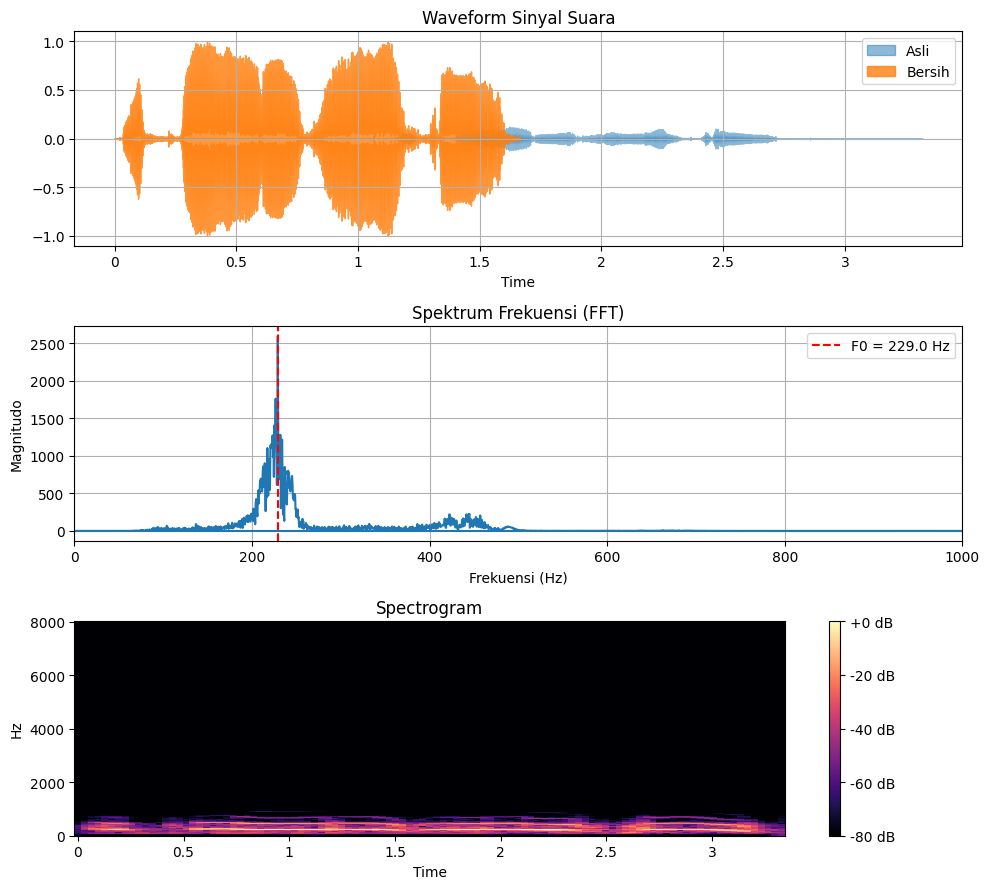

In [4]:
Anak_Cewe1 = '/content/Audio_Project/dataset_wav/anak_cewe/anak_cewe.wav'
process_single_file(Anak_Cewe1)


Memproses: /content/Audio_Project/dataset_wav/anak_cewe/anak_cewe2.wav
F0: 374.0 Hz
Kategori: Anak-anak (frekuensi tinggi)


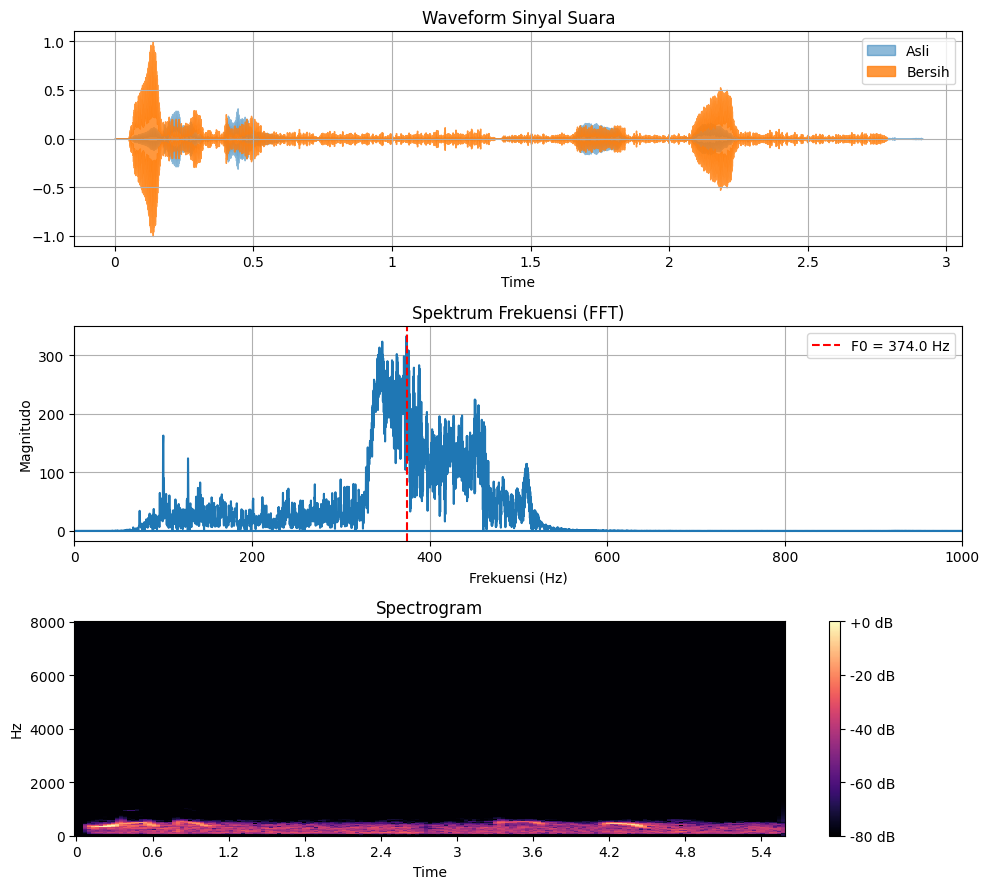

In [5]:
Anak_Cewe2 = '/content/Audio_Project/dataset_wav/anak_cewe/anak_cewe2.wav'
process_single_file(Anak_Cewe2)


Memproses: /content/Audio_Project/dataset_wav/anak_cewe/anak_cewe3.wav
F0: 330.1 Hz
Kategori: Anak-anak (frekuensi tinggi)


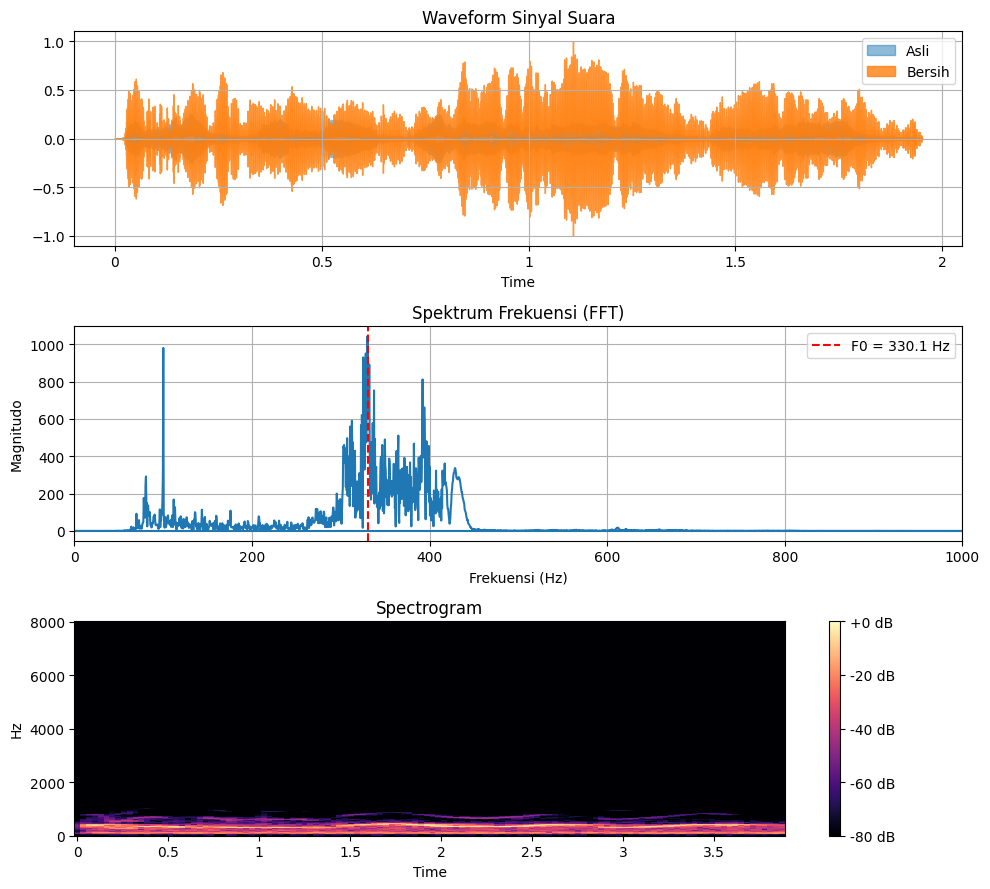

In [6]:
Anak_Cewe3 = '/content/Audio_Project/dataset_wav/anak_cewe/anak_cewe3.wav'
process_single_file(Anak_Cewe3)

**Anak_Cowo**


Memproses: /content/Audio_Project/dataset_wav/bayi/bayi_laki3.wav
F0: 365.5 Hz
Kategori: Anak-anak (frekuensi tinggi)


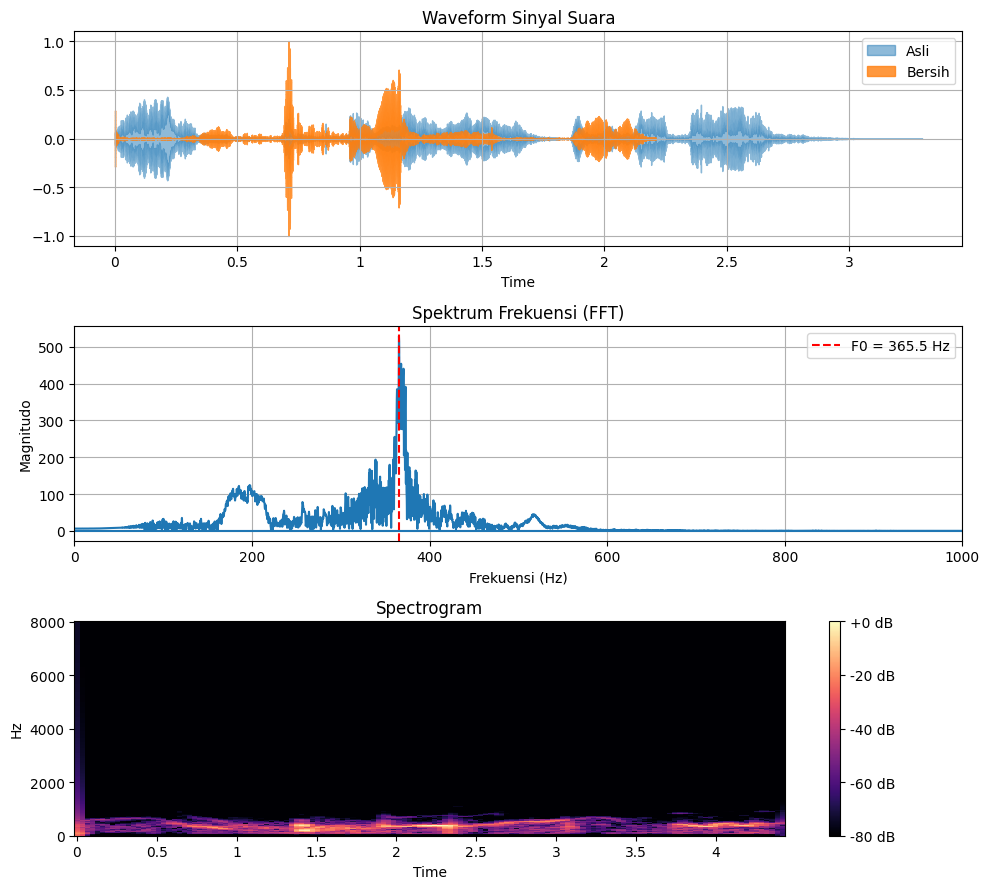

In [7]:
Bayi_Laki1 = '/content/Audio_Project/dataset_wav/bayi/bayi_laki3.wav'
process_single_file(Bayi_Laki1)


Memproses: /content/Audio_Project/dataset_wav/anak_laki/anak_laki.wav
F0: 261.2 Hz
Kategori: Anak-anak Laki-laki


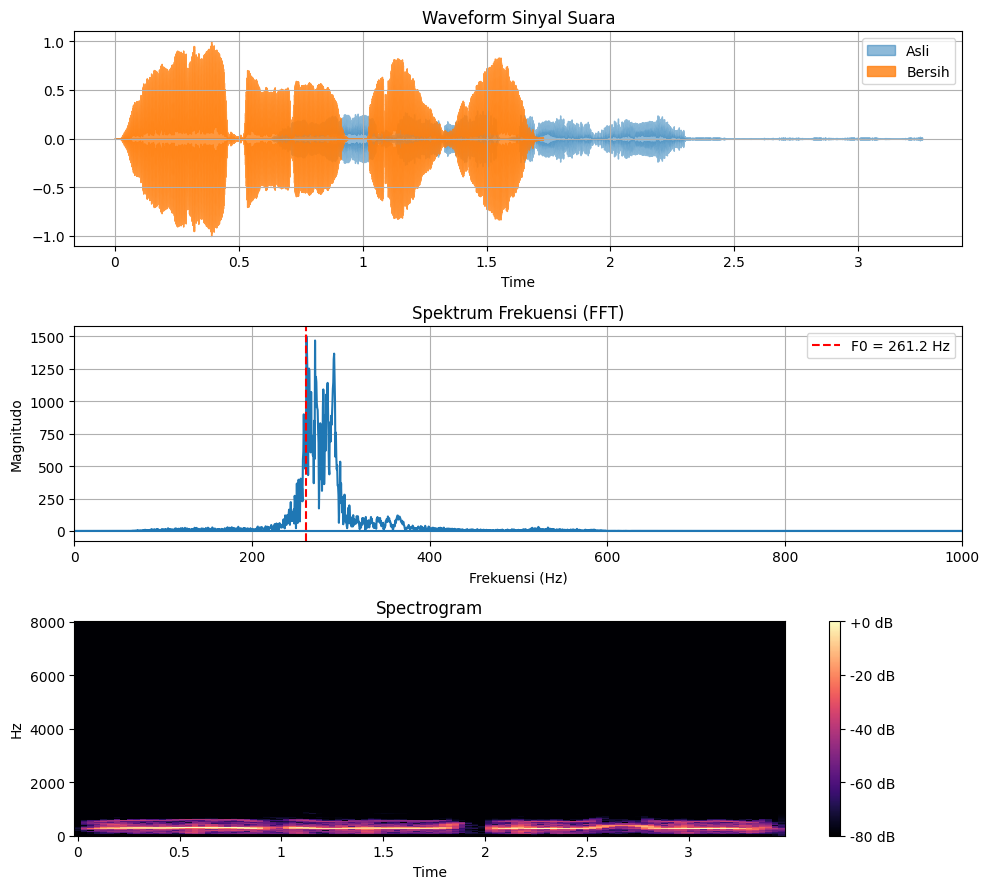

In [8]:
Anak_laki1 = '/content/Audio_Project/dataset_wav/anak_laki/anak_laki.wav'
process_single_file(Anak_laki1)


Memproses: /content/Audio_Project/dataset_wav/anak_laki/anak_laki2.wav
F0: 305.7 Hz
Kategori: Anak-anak (frekuensi tinggi)


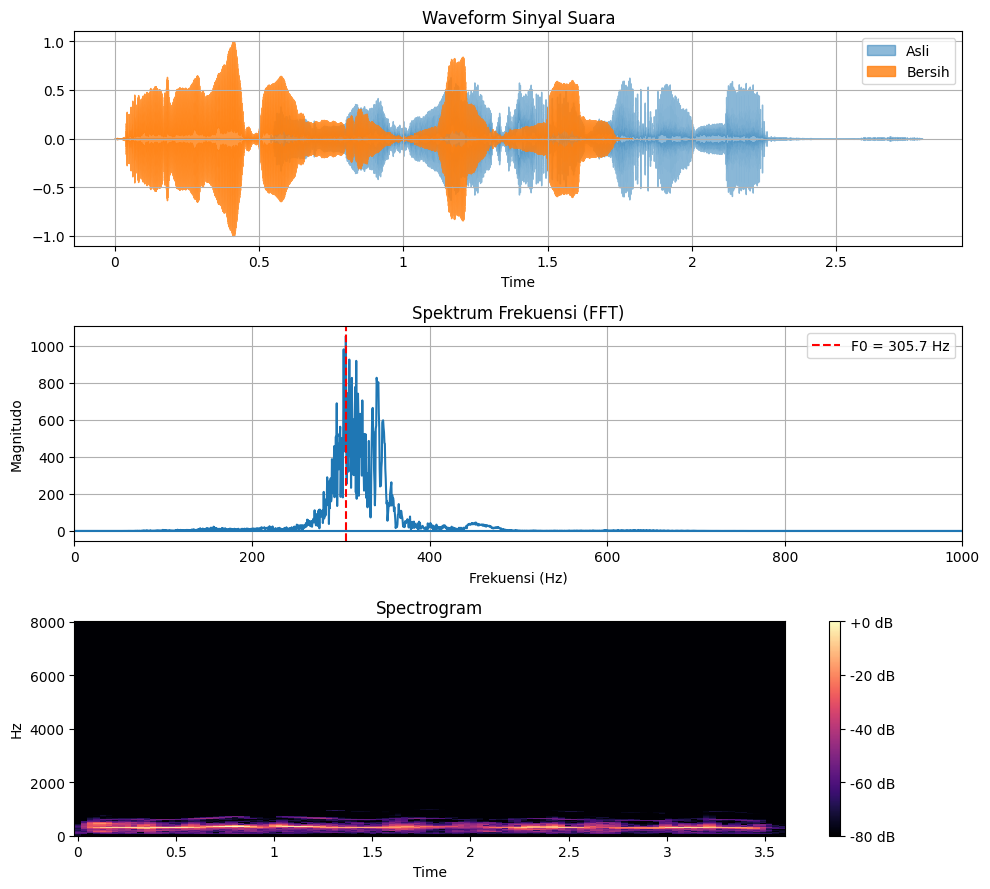

In [9]:
Anak_laki2 = '/content/Audio_Project/dataset_wav/anak_laki/anak_laki2.wav'
process_single_file(Anak_laki2)

### **Suara Orang Dewasa**

### **Dewasa Cewe**


Memproses: /content/Audio_Project/dataset_wav/dewasa_cewe/Remaja_cewe1.wav
F0: 216.8 Hz
Kategori: Anak-anak Laki-laki


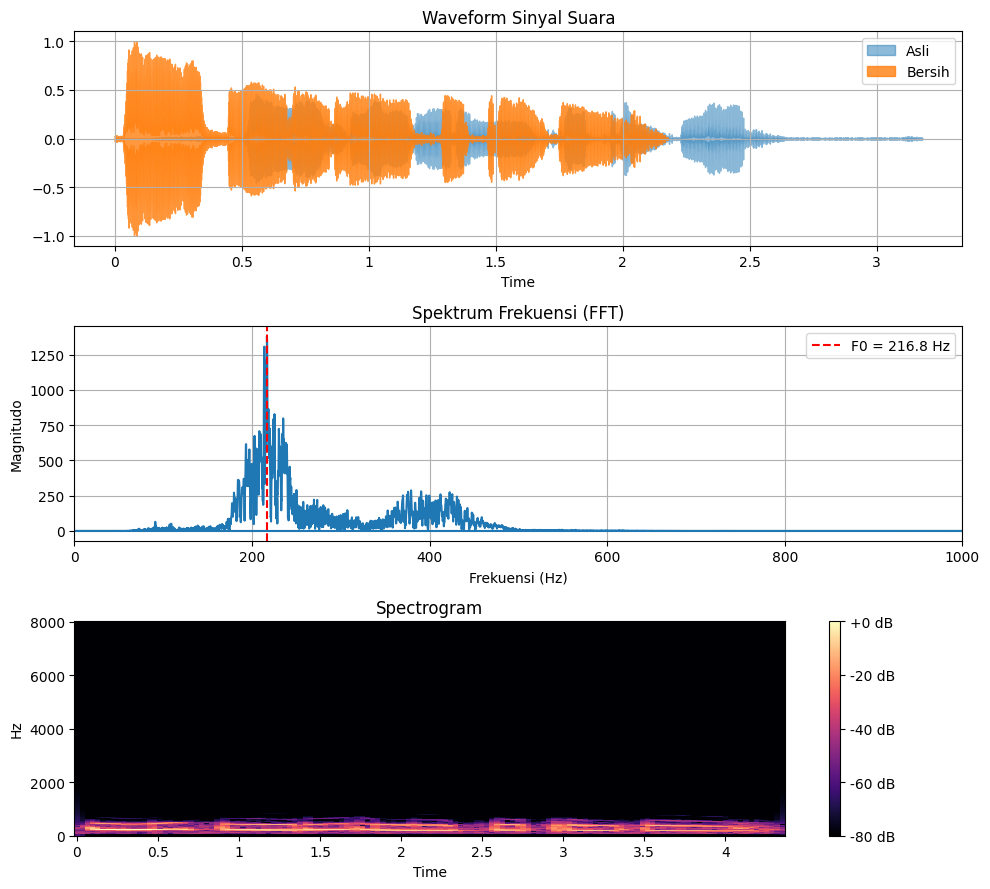

In [10]:
Remaja_Cewe1 = '/content/Audio_Project/dataset_wav/dewasa_cewe/Remaja_cewe1.wav'
process_single_file(Remaja_Cewe1)


Memproses: /content/Audio_Project/dataset_wav/dewasa_cewe/dewasa_cewe.wav
F0: 182.6 Hz
Kategori: Lansia Perempuan (45–65 tahun)


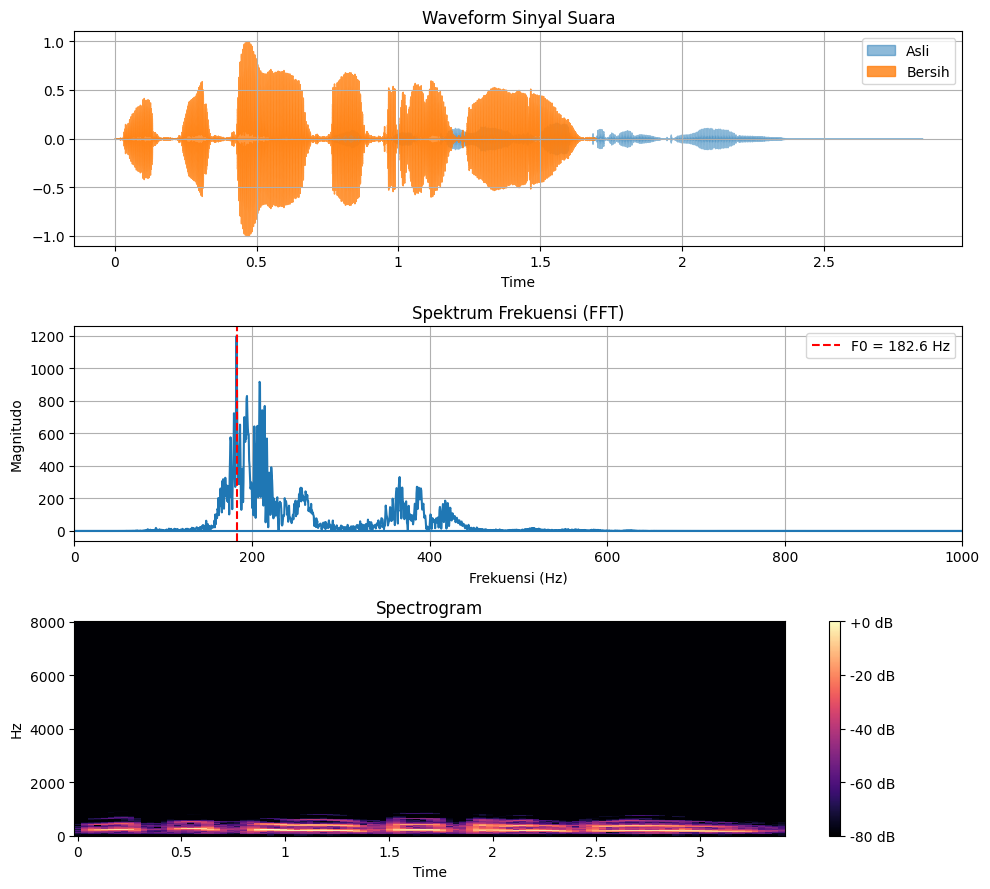

In [11]:
Dewasa_Wanita1 = '/content/Audio_Project/dataset_wav/dewasa_cewe/dewasa_cewe.wav'
process_single_file(Dewasa_Wanita1)


Memproses: /content/Audio_Project/dataset_wav/dewasa_cewe/dewasa_cewe3.wav
F0: 395.8 Hz
Kategori: Anak-anak (frekuensi tinggi)


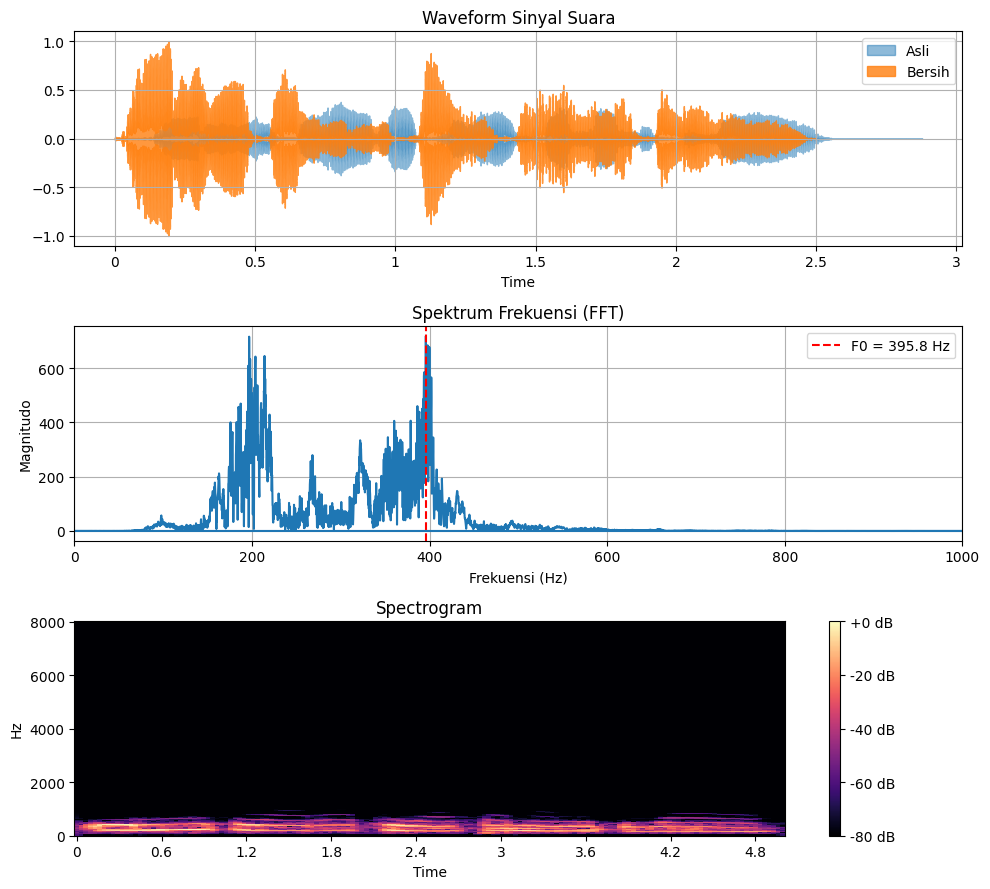

In [12]:
Dewasa_Wanita2 = '/content/Audio_Project/dataset_wav/dewasa_cewe/dewasa_cewe3.wav'
process_single_file(Dewasa_Wanita2)

## **Dewasa Laki Laki**


Memproses: /content/Audio_Project/dataset_wav/dewasa_laki/REMAJA LAKI (1).wav
F0: 112.8 Hz
Kategori: Lansia Laki-laki (45–65 tahun)


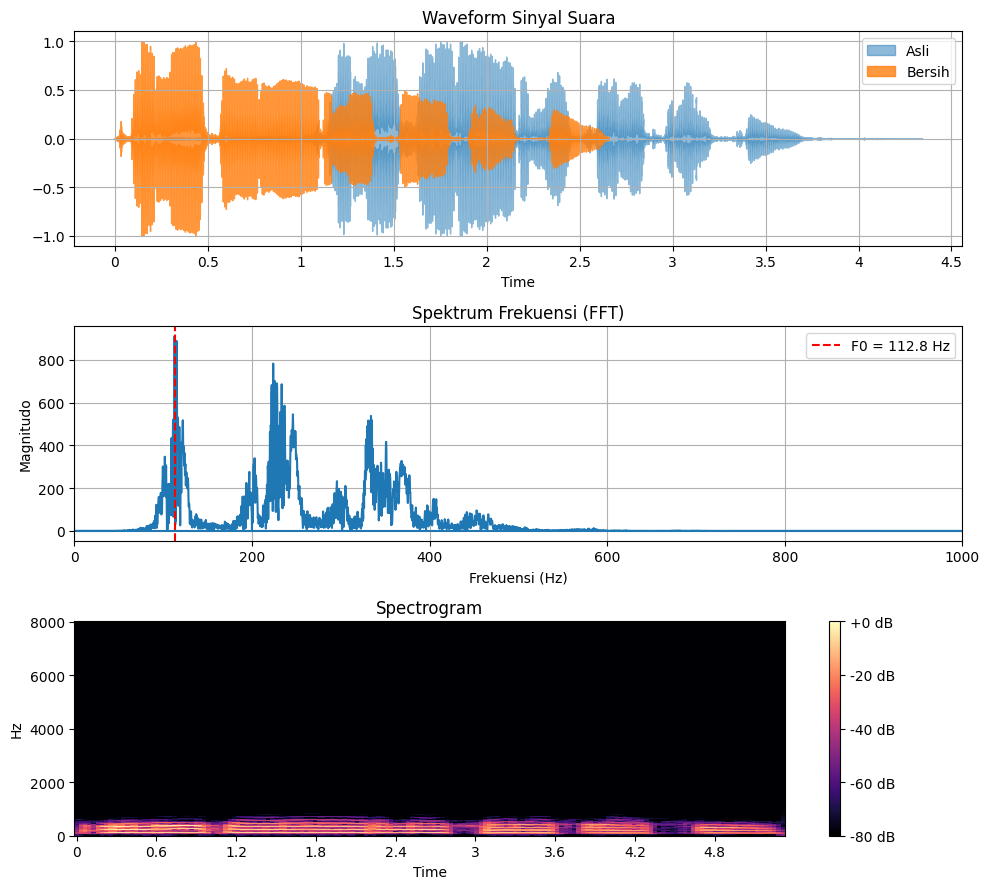

In [13]:
Remaja_Cowo1 = '/content/Audio_Project/dataset_wav/dewasa_laki/REMAJA LAKI (1).wav'
process_single_file(Remaja_Cowo1)


Memproses: /content/Audio_Project/dataset_wav/dewasa_laki/remaja_laki3.wav
F0: 212.0 Hz
Kategori: Anak-anak Laki-laki


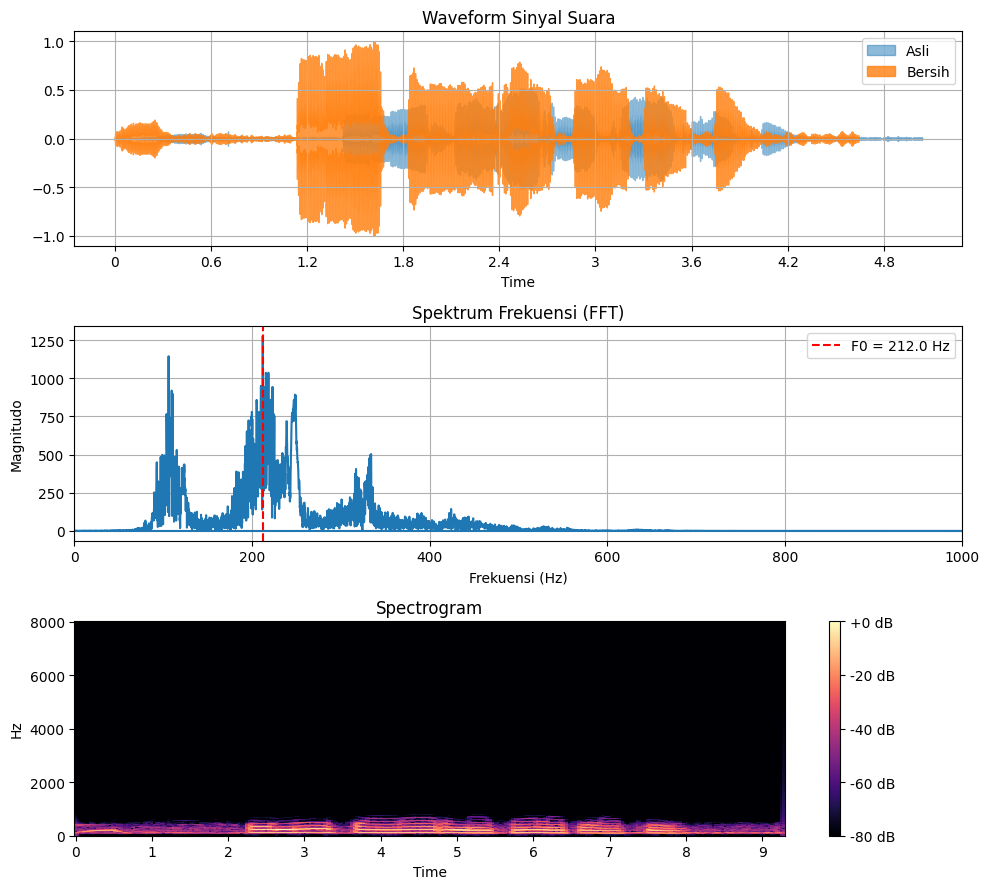

In [14]:
Remaja_Laki3 = '/content/Audio_Project/dataset_wav/dewasa_laki/remaja_laki3.wav'
process_single_file(Remaja_Laki3)


Memproses: /content/Audio_Project/dataset_wav/dewasa_laki/DEWASA LAKI.wav
F0: 138.7 Hz
Kategori: Dewasa Laki-laki (17–45 tahun)


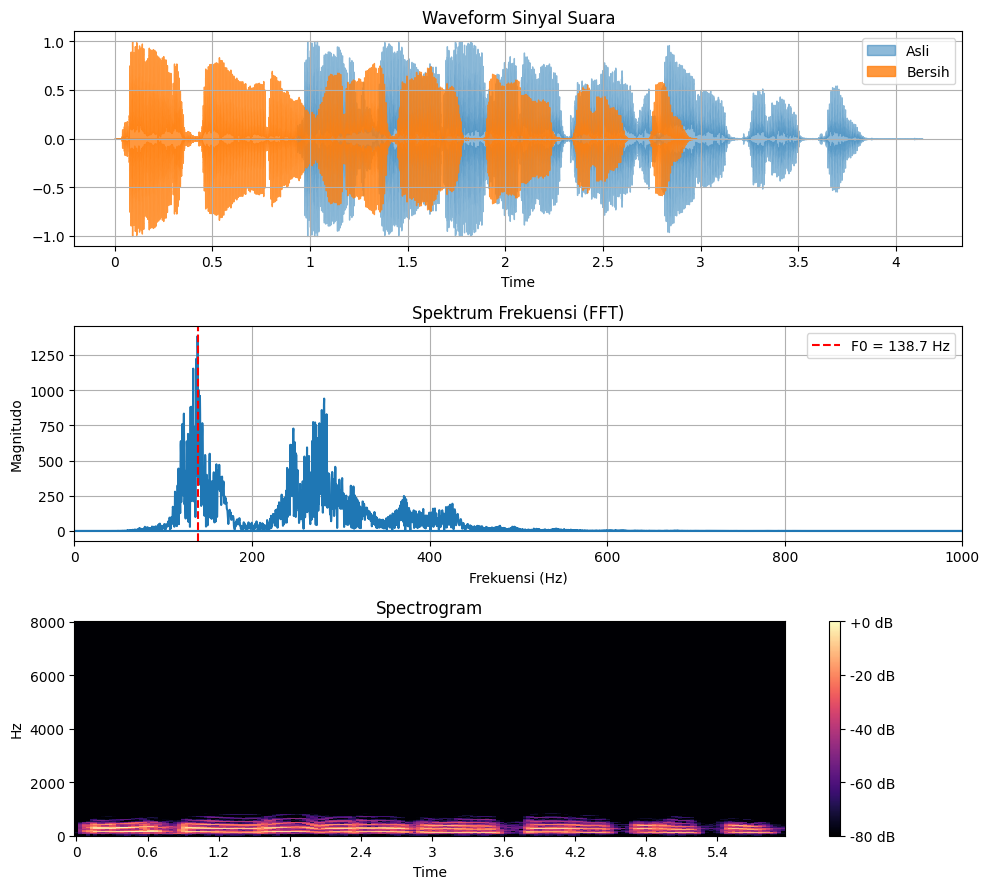

In [15]:
Dewasa_Laki1 = '/content/Audio_Project/dataset_wav/dewasa_laki/DEWASA LAKI.wav'
process_single_file(Dewasa_Laki1)

## **Suara Lansia**

**Lansia Pria**


Memproses: /content/Audio_Project/dataset_wav/lansia_laki/lansia_laki.wav
F0: 257.8 Hz
Kategori: Anak-anak Laki-laki


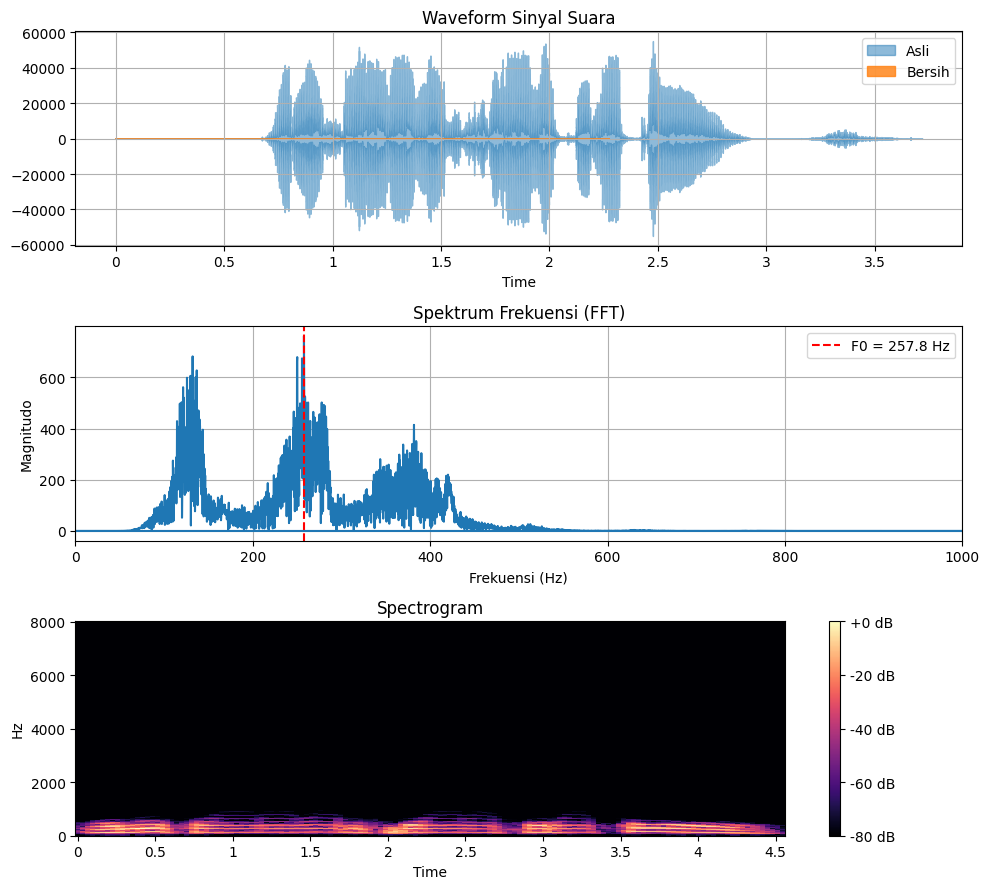

In [16]:
Lansia_Pria1 = '/content/Audio_Project/dataset_wav/lansia_laki/lansia_laki.wav'
process_single_file(Lansia_Pria1)


Memproses: /content/Audio_Project/dataset_wav/lansia_laki/lansia_laki_2.wav
F0: 181.6 Hz
Kategori: Lansia Perempuan (45–65 tahun)


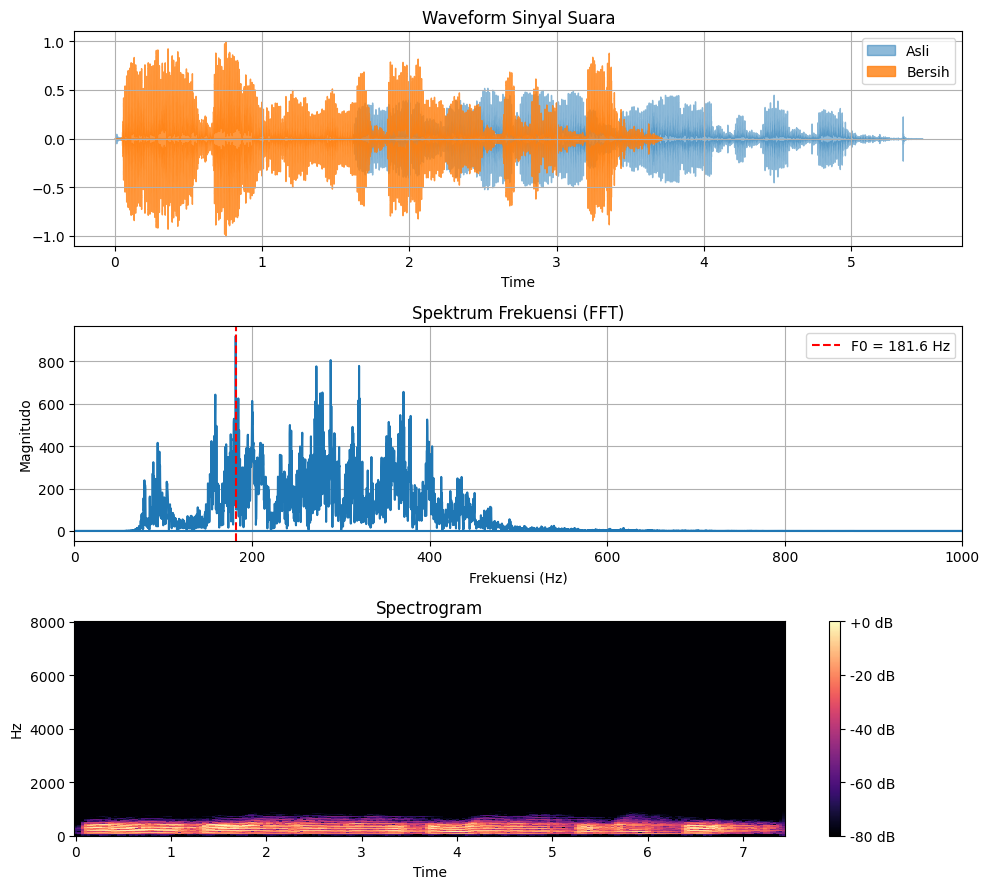

In [17]:
Lansia_Pria2 = '/content/Audio_Project/dataset_wav/lansia_laki/lansia_laki_2.wav'
process_single_file(Lansia_Pria2)


Memproses: /content/Audio_Project/dataset_wav/lansia_laki/lansia_laki3.wav
F0: 203.6 Hz
Kategori: Anak-anak Perempuan


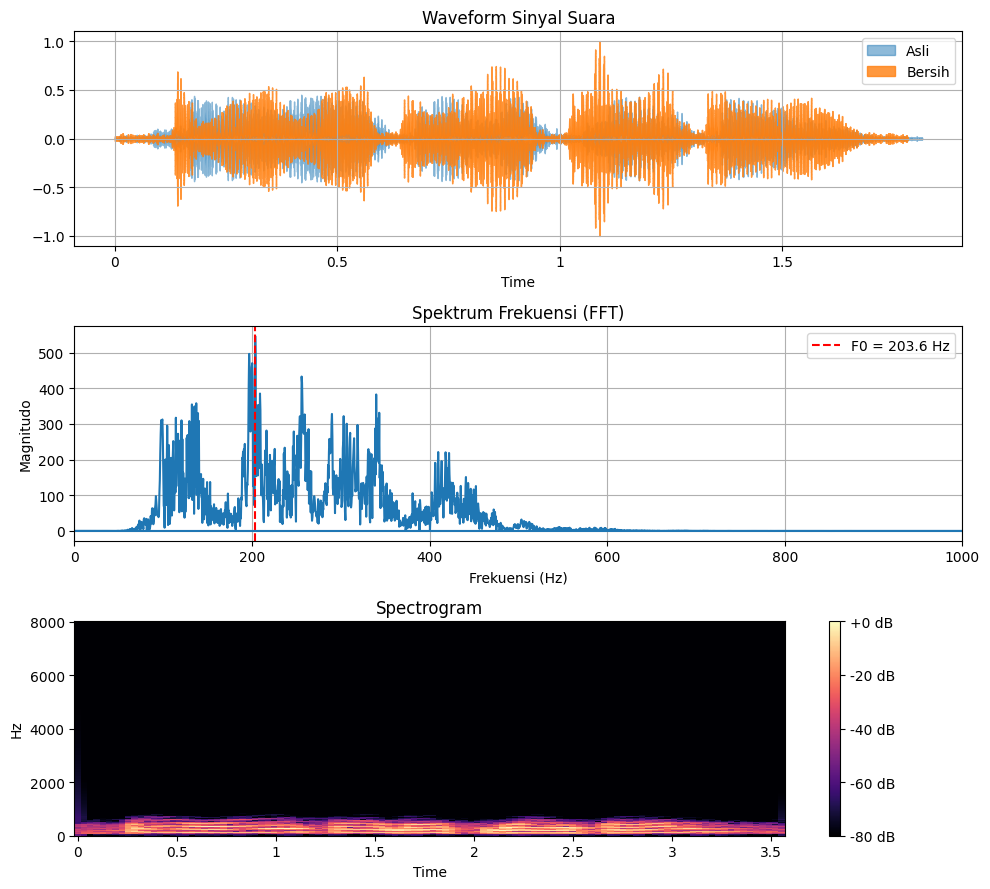

In [18]:
Lansia_Pria3 = '/content/Audio_Project/dataset_wav/lansia_laki/lansia_laki3.wav'
process_single_file(Lansia_Pria3)

**Lansia Wanita**


Memproses: /content/Audio_Project/dataset_wav/lansia_cewe/lansia_cewe.wav
F0: 387.0 Hz
Kategori: Anak-anak (frekuensi tinggi)


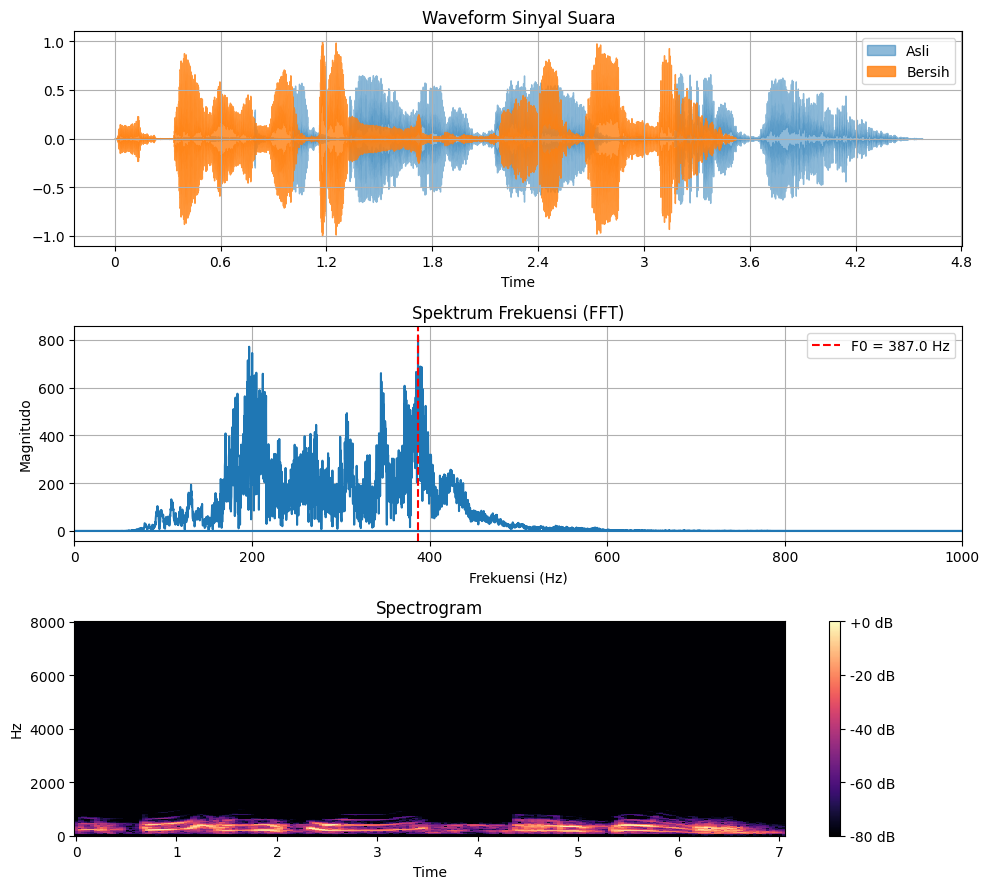

In [19]:
Lansia_Wanita1 = '/content/Audio_Project/dataset_wav/lansia_cewe/lansia_cewe.wav'
process_single_file(Lansia_Wanita1)


Memproses: /content/Audio_Project/dataset_wav/lansia_cewe/lansia_cewe_2.wav
F0: 291.0 Hz
Kategori: Anak-anak (frekuensi tinggi)


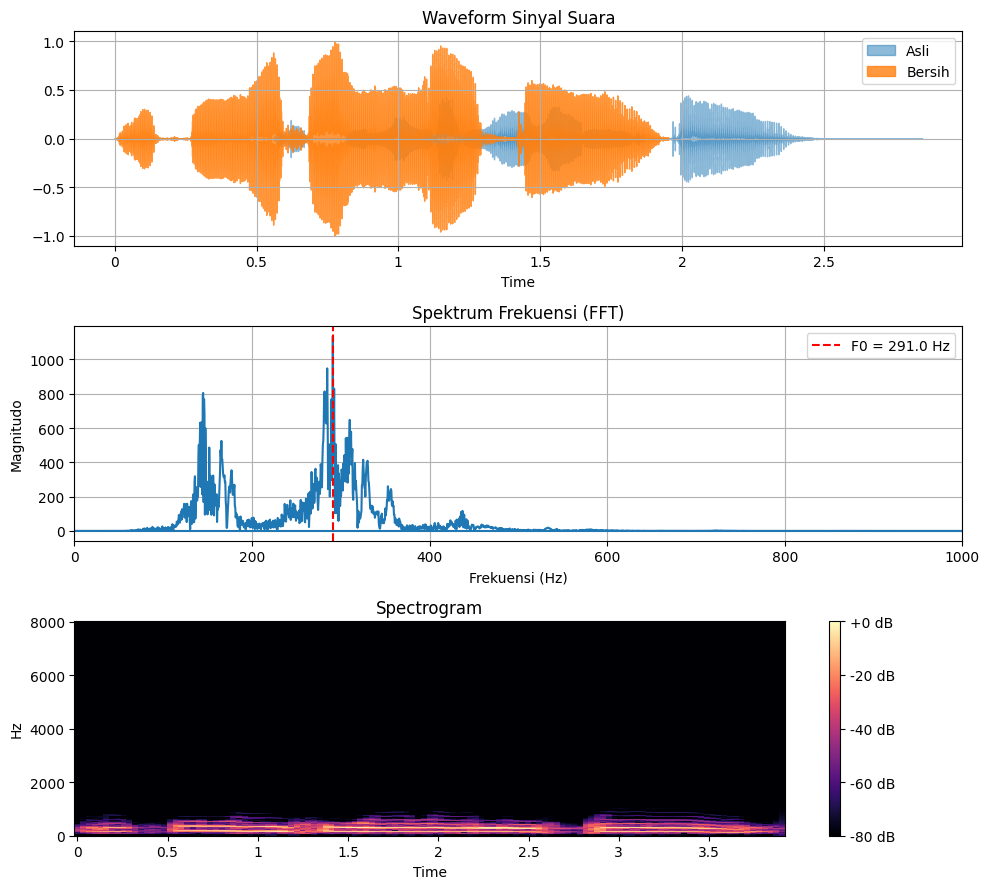

In [20]:
Lansia_Wanita2 = '/content/Audio_Project/dataset_wav/lansia_cewe/lansia_cewe_2.wav'
process_single_file(Lansia_Wanita2)


Memproses: /content/Audio_Project/dataset_wav/lansia_cewe/lansia_cewe_3.wav
F0: 214.6 Hz
Kategori: Anak-anak Laki-laki


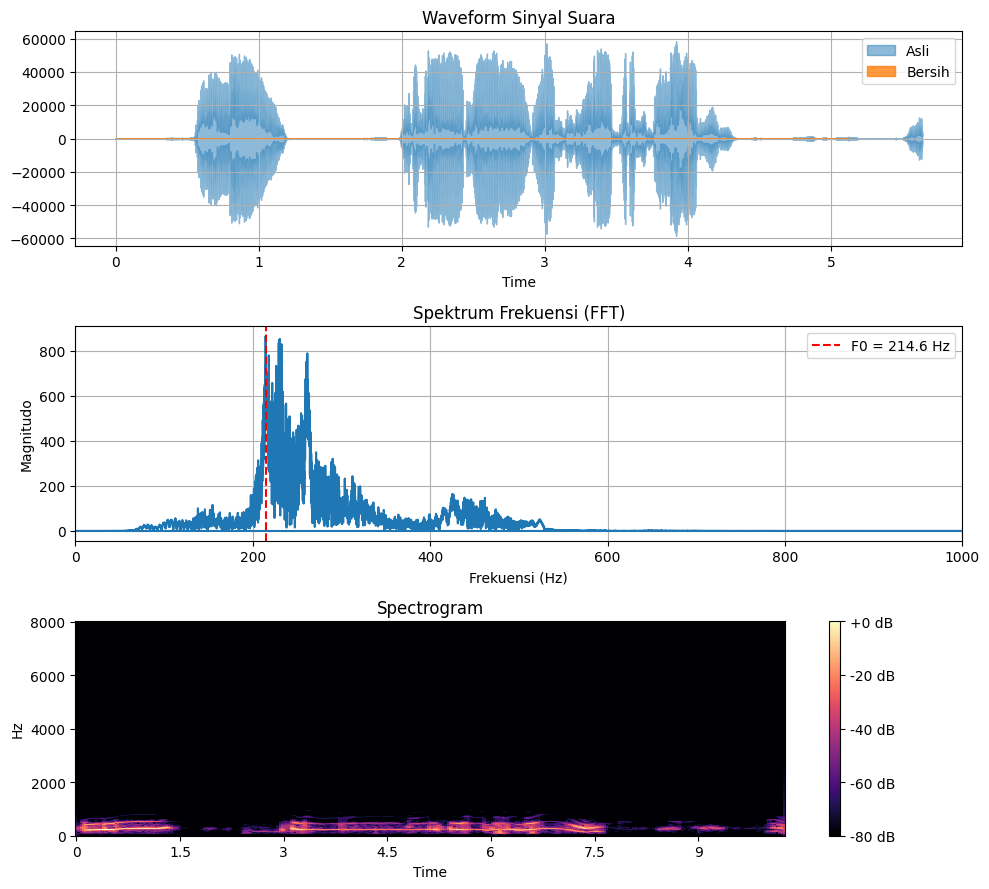

In [21]:
Lansia_Wanita3 = '/content/Audio_Project/dataset_wav/lansia_cewe/lansia_cewe_3.wav'
process_single_file(Lansia_Wanita3)